In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

#Define Load embed
def load_embed(ind):
    doc_embed   = tf.constant(np.load(f"embeds/doc_embed_{ind}.npy"))
    word_embed  = tf.constant(np.load(f"embeds/word_embed_{ind}.npy"))
    topic_embed = tf.constant(np.load(f"embeds/topic_embed_{ind}.npy"))
    return (doc_embed, word_embed, topic_embed)

#Define Topic Dist
def topic_dist(ind):
    embeds = load_embed(ind)
    doc_embed = embeds[0]
    topic_embed = embeds[2]
    norm_doc = tf.nn.softmax(doc_embed)
    topic_dist = tf.linalg.matmul(norm_doc, topic_embed)
    return topic_dist

In [2]:
#Load Data
data = topic_dist(0)
print(data.shape)
#Remove last 10 rows (aka 2017. Cant predict 2018 without data)
inputs = data[:-10, :]
print(inputs.shape)
#Remove first 10 rows (aka 2008. Cant predict to 2008 without prev data)
outputs = data[10:, :]
print(outputs.shape)

(100, 300)
(90, 300)
(90, 300)


Epoch 1/100
9/9 [==============================] - 0s 1ms/step - loss: -0.1790 - acc: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: -0.4347 - acc: 0.0111
Epoch 3/100
9/9 [==============================] - 0s 1ms/step - loss: -0.4625 - acc: 0.0556
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: -0.5037 - acc: 0.0556
Epoch 5/100
9/9 [==============================] - 0s 1ms/step - loss: -0.5432 - acc: 0.0667
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: -0.5727 - acc: 0.0778
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: -0.5936 - acc: 0.0778
Epoch 8/100
9/9 [==============================] - 0s 1ms/step - loss: -0.6074 - acc: 0.0889
Epoch 9/100
9/9 [==============================] - 0s 1ms/step - loss: -0.6182 - acc: 0.0889
Epoch 10/100
9/9 [==============================] - 0s 1ms/step - loss: -0.6260 - acc: 0.0778
Epoch 11/100
9/9 [==============================] - 0s 1ms/step -

9/9 [==============================] - 0s 1ms/step - loss: -0.9835 - acc: 0.4333
Epoch 89/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9829 - acc: 0.4667
Epoch 90/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9832 - acc: 0.4667
Epoch 91/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9834 - acc: 0.4556
Epoch 92/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9844 - acc: 0.4333
Epoch 93/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9853 - acc: 0.5333
Epoch 94/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9857 - acc: 0.4222
Epoch 95/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9864 - acc: 0.4778
Epoch 96/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9865 - acc: 0.4667
Epoch 97/100
9/9 [==============================] - 0s 1ms/step - loss: -0.9870 - acc: 0.4333
Epoch 98/100
9/9 [==============================] - 0s 1ms/step - loss: -

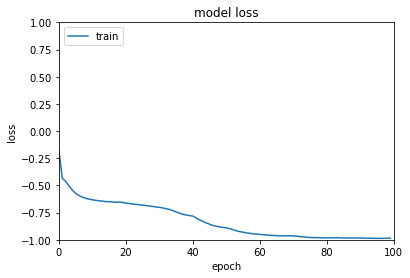

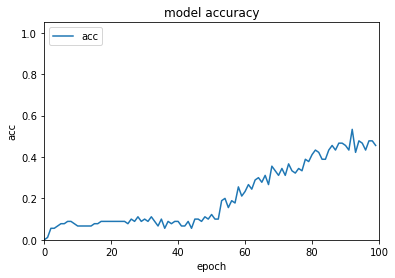

In [3]:
input_size = 300
hidden_size1 = 300
hidden_size2 = 300
hidden_size3 = 300
output_size = 300

input_data = Input(shape=(input_size,))
hidden_d_1 = Dense(hidden_size1, activation='tanh')(input_data)
hidden_d_2 = Dense(hidden_size2, activation='tanh')(hidden_d_1)
hidden_d_3 = Dense(hidden_size3, activation='tanh')(hidden_d_2)
predicted = Dense(output_size, activation='tanh')(hidden_d_3)

predictor = Model(input_data, predicted)
predictor.compile(optimizer='Adam', loss='cosine_similarity', metrics=['acc'] ) #Can also do MSE or MAE here for loss.

p = predictor.fit(inputs, outputs,
epochs=100,
batch_size=10,
shuffle=False)
#validation_data=(X_test, Y_test))

#Plotting loss
plt.plot(p.history['loss'])
#plt.plot(p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 100, -1, 1])
plt.show()

#Plotting Accuracy
plt.plot(p.history['acc'])
#plt.plot(p.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['acc'], loc='upper left')
#plt.legend(['acc', 'val_acc'], loc='upper left')
plt.axis([0, 100, 0.0, 1.05])
plt.show()